In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Append the parent directory to sys.path
sys.path.append(parent_dir)

# Verify that the parent directory was added
print(sys.path[-1])

/home/yuki/quant_project/EURUSD-LSTM-prediction


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import *
import matplotlib.pyplot as plt
import seaborn

# Set the random seed
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("../Data/EURUSD_Macro.csv")
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.dropna(inplace=True)
df_Macro

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,EURUSDV1W Curncy,EURUSDV1M Curncy,EURUSDV1Y Curncy,EURUSD25R1M Curncy,EURON Curncy,...,GTFRF2Y Govt,GTFRF10Y Govt,GTFRF30Y Govt,SPX Index,VIX Index,SX5E Index,CPI YOY Index,EACPI Index,Last_Return,Predict_Return
1,10/3/2003,1.1695,1.1722,1.1554,1.1580,11.3500,11.1500,11.2000,0.7000,-1.055,...,2.534,4.262,4.971,1029.85,19.50,2516.48,2.3,81.54,-0.009918,0.011226
2,10/6/2003,1.1563,1.1723,1.1535,1.1710,10.6000,11.3500,11.2250,0.7000,-0.335,...,2.475,4.217,4.918,1034.35,19.51,2497.10,2.3,81.54,0.011226,0.004355
3,10/7/2003,1.1710,1.1814,1.1700,1.1761,11.2500,11.6500,11.4000,0.8000,-0.345,...,2.476,4.249,4.959,1039.25,19.41,2476.61,2.3,81.54,0.004355,0.004336
4,10/8/2003,1.1761,1.1840,1.1760,1.1812,11.1250,11.6250,11.3500,0.8000,-0.373,...,2.462,4.238,4.951,1033.78,19.18,2473.88,2.3,81.54,0.004336,-0.005418
5,10/9/2003,1.1811,1.1860,1.1687,1.1748,11.5000,11.3000,11.2000,0.7750,-1.420,...,2.526,4.299,4.995,1038.73,18.82,2531.37,2.3,81.54,-0.005418,0.004256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,7/15/2024,1.0903,1.0922,1.0882,1.0894,4.6725,5.0475,6.1700,-0.1475,0.494,...,2.948,3.112,3.591,5631.22,13.12,4983.11,3.0,126.58,-0.001192,0.000459
5423,7/16/2024,1.0894,1.0905,1.0872,1.0899,4.5475,5.0575,6.1750,-0.1450,0.499,...,2.914,3.081,3.560,5667.20,13.19,4947.83,3.0,126.58,0.000459,0.003670
5424,7/17/2024,1.0899,1.0948,1.0895,1.0939,5.0075,5.2550,6.1750,-0.1375,0.498,...,2.924,3.075,3.551,5588.27,14.48,4891.46,3.0,126.58,0.003670,-0.003839
5425,7/18/2024,1.0939,1.0941,1.0894,1.0897,4.3325,5.0300,6.2175,-0.2125,0.500,...,2.909,3.091,3.579,5544.59,15.93,4870.12,3.0,126.58,-0.003839,-0.001377


In [3]:
df_Macro.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'EURUSDV1W Curncy',
       'EURUSDV1M Curncy', 'EURUSDV1Y Curncy', 'EURUSD25R1M Curncy',
       'EURON Curncy', 'EURUSDVON Curncy', 'EUR1M Curncy', 'EUR12M Curncy',
       'DXY Curncy', 'GOLDS Comdty', 'CL1 Comdty', 'FEDL01 Index',
       'LF94TRUU Index', 'USGG2YR Index', 'USGG10YR Index', 'USGG30YR Index',
       'GTDEM2Y Govt', 'GTDEM10Y Govt', 'GTDEM30Y Govt', 'GTFRF2Y Govt',
       'GTFRF10Y Govt', 'GTFRF30Y Govt', 'SPX Index', 'VIX Index',
       'SX5E Index', 'CPI YOY Index', 'EACPI Index', 'Last_Return',
       'Predict_Return'],
      dtype='object')

In [4]:
split_point = int(df_Macro.shape[0]*0.9)
df_train = df_Macro.iloc[:split_point,:]
df_test = df_Macro.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)

threshold = 0.002

0.001947


In [5]:
y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = test_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

149
209
164


In [6]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':5,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.75}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()


def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()

    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    print(f"test loss is {test_loss}")
        
  return [loss_train, loss_test]   



def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")

    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
    
  return loss_ls

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [7]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 100
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.614368512941274
test loss is 1.6852098595912444
-----------------------Epoch: 2----------------------------------
train loss is 1.4871398275827943
test loss is 1.5006140125131164
-----------------------Epoch: 3----------------------------------
train loss is 1.427833504572896
test loss is 1.4412213885418694
-----------------------Epoch: 4----------------------------------
train loss is 1.385703525607457
test loss is 1.3426188552376648
-----------------------Epoch: 5----------------------------------
train loss is 1.3264485367663033
test loss is 1.400678720600103
-----------------------Epoch: 6----------------------------------
train loss is 1.2931373718142531
test loss is 1.2763181809062871
-----------------------Epoch: 7----------------------------------
train loss is 1.2553490548426511
test loss is 1.2680294843502884
-----------------------Epoch: 8----------------------------------
train loss is 1.22379

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


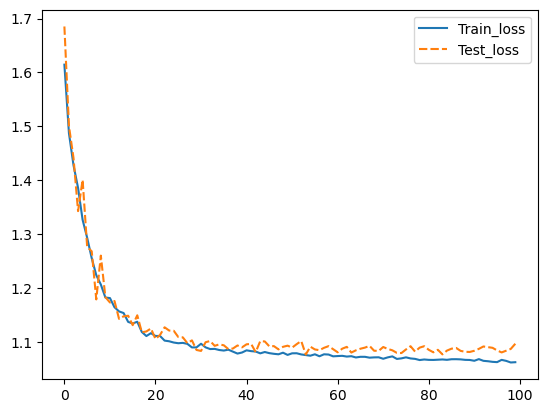

In [8]:
loss_df = pd.DataFrame(data=np.array(loss_ls),columns=["Train_loss", "Test_loss"])
seaborn.lineplot(data=loss_df)
plt.show()

In [9]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))
net_test.eval()

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.39846743295019155

In [10]:
act_predict_bool = (predict_results != 1) 

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)


0.31976744186046513

In [11]:
act_predict_results.shape


torch.Size([172])

In [12]:
saved_path = "../trained_model/EURUSD_Mac_LSTM.pth"

torch.save(net_test.state_dict(),saved_path )